In [1]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
import torch
import sklearn
from weapon_data import WeaponData
from cnn import CnnNet
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import itertools
%config InlineBackend.figure_format = 'svg'


In [2]:
dataset = WeaponData()


['not_pistol', 'pistol']


In [3]:
net = CnnNet(64, len(dataset.classes),  c_kernels=[3, 3, 3, 3, 3, 3], in_channels=[3, 16, 32, 64, 86, 128, 128], out_channels=[16, 32, 64, 86, 128, 128])
criterion = nn.NLLLoss()
lr = 0.001
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
loss_test = []

ilość klas: 2
wielkość po warstawach conv: 10


In [4]:
if torch.cuda.is_available():
    net = net.cuda()
    net.cnn = net.cnn.cuda()
    print("GPU is available")
else:
    torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [5]:
def valid_classification(out, d):
    """
        Function calculating valid classification
        @ out - netowerk output
        @ d - destination value
        return: classification correctness in %
        """
    out = out.cpu().detach().numpy()
    d = d.cpu().detach().numpy()
    temp = abs(d - out)
    valid = sum(i < 0.5 for i in temp)
    return valid / temp.shape[0] * 100  # type:ignore


start


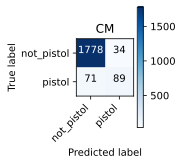

pk: 94.71 %
Learning rate: 0.0010000000
Epoch: 0............. Loss: 0.1442


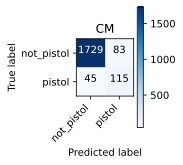

pk: 93.41 %
Learning rate: 0.0010000000
Epoch: 1............. Loss: 0.1508


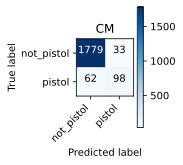

pk: 95.09 %
Learning rate: 0.0010000000
Epoch: 2............. Loss: 0.0249


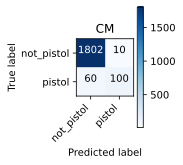

pk: 96.50 %
Learning rate: 0.0010000000
Epoch: 3............. Loss: 0.0372


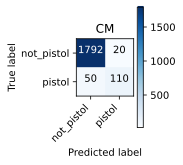

pk: 96.44 %
Learning rate: 0.0010000000
Epoch: 4............. Loss: 0.0390


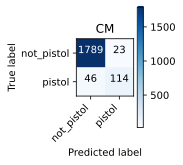

pk: 96.53 %
Learning rate: 0.0010000000
Epoch: 5............. Loss: 0.0359


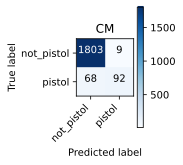

pk: 96.13 %
Learning rate: 0.0010000000
Epoch: 6............. Loss: 0.0185


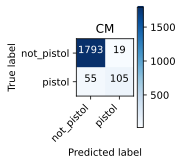

pk: 96.20 %
Learning rate: 0.0010000000
Epoch: 7............. Loss: 0.0334


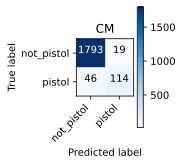

pk: 96.73 %
Learning rate: 0.0010000000
Epoch: 8............. Loss: 0.0121


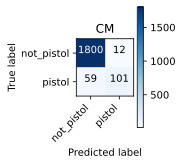

pk: 96.45 %
Learning rate: 0.0010000000
Epoch: 9............. Loss: 0.0532


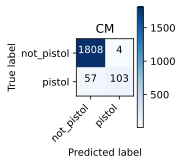

pk: 96.87 %
Learning rate: 0.0010000000
Epoch: 10............. Loss: 0.0256


In [6]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=cm.Blues, show=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'CM'

    # Calculate chart area size
    leftmargin = 0.5  # inches
    rightmargin = 0.5  # inches
    categorysize = 0.5  # inches
    figwidth = leftmargin + rightmargin + (len(classes) * categorysize)

    f = plt.figure(figsize=(figwidth, figwidth))

    # Create an axes instance and ajust the subplot size
    ax = f.add_subplot(111)
    ax.set_aspect(1)
    f.subplots_adjust(left=leftmargin/figwidth, right=1-rightmargin/figwidth, top=0.94, bottom=0.1)

    res = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar(res)
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if show:
        plt.show()
        plt.close(f)
    else:
        plt.close(f)
            
def test():
    loss_t = 0
    pk = []
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, labels in dataset.testloader:
            labels = labels.cuda()
            data = data.cuda()
            out, _ = net(data)
            output = torch.argmax(out.detach(), dim=1)
            loss = criterion(out, labels)
            loss_t += loss.cpu().item()
            y_true = np.append(y_true, labels.cpu().detach().numpy(), 0)
            y_pred = np.append(y_pred, output.cpu().detach().numpy(), 0)
            pk.append(valid_classification(output, labels))
    mtrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    loss_test.append(loss_t)
    return (np.average(pk), mtrix)  # type:ignore


# sourcery skip: hoist-statement-from-loop
loss = 0
for e in range(100):
    old_param = net.parameters
    # pass through all data
    for data, exp in dataset.trainloader:
        exp = exp.cuda()
        # pass data to cuda
        data = data.cuda()
        # clear gradient from previous epoch
        optimizer.zero_grad()
        out, sample = net(data)
        loss = criterion(out, exp)
        loss.backward()
        optimizer.step()

    pk, mat = test()
    plot_confusion_matrix(mat, dataset.classes)
   
    temp_lr: float = optimizer.param_groups[0]['lr']
    print("pk: {:.2f} %".format(pk))
    print("Learning rate: {:.10f}".format(temp_lr))
    print('Epoch: {}.............'.format(e), end=' ')
    print("Loss: {:.4f}".format(loss))
    
torch.save(net, "models/weapon")

